# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

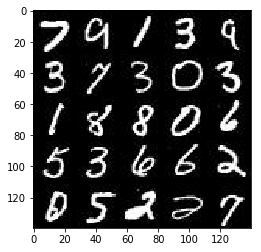

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

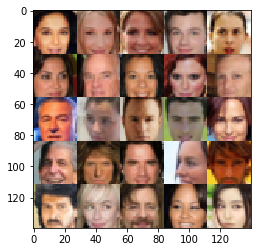

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),'real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha=0.2
    x = images
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(x, 64, 4, strides=2, padding="same")
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)

        x = tf.layers.conv2d(x, 128, 4, strides=2, padding="same")
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)

        x = tf.layers.conv2d(x, 256, 4, strides=2, padding="same")
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)

        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
    
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    smooth = 0.1
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 0.9, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6557... Generator Loss: 11.4735
Epoch 1/2... Discriminator Loss: 2.1227... Generator Loss: 0.4311
Epoch 1/2... Discriminator Loss: 0.6873... Generator Loss: 4.4978
Epoch 1/2... Discriminator Loss: 0.5232... Generator Loss: 5.8044
Epoch 1/2... Discriminator Loss: 0.5247... Generator Loss: 2.5595
Epoch 1/2... Discriminator Loss: 0.6784... Generator Loss: 1.7060
Epoch 1/2... Discriminator Loss: 0.6547... Generator Loss: 5.3234
Epoch 1/2... Discriminator Loss: 0.4314... Generator Loss: 3.9011
Epoch 1/2... Discriminator Loss: 0.5183... Generator Loss: 2.5770
Epoch 1/2... Discriminator Loss: 0.7344... Generator Loss: 1.3609


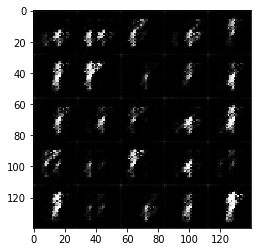

Epoch 1/2... Discriminator Loss: 0.7772... Generator Loss: 1.9616
Epoch 1/2... Discriminator Loss: 0.5265... Generator Loss: 3.4379
Epoch 1/2... Discriminator Loss: 0.5308... Generator Loss: 3.5500
Epoch 1/2... Discriminator Loss: 0.5773... Generator Loss: 2.2808
Epoch 1/2... Discriminator Loss: 0.5407... Generator Loss: 2.5841
Epoch 1/2... Discriminator Loss: 2.1974... Generator Loss: 8.6220
Epoch 1/2... Discriminator Loss: 0.5309... Generator Loss: 2.8290
Epoch 1/2... Discriminator Loss: 0.5477... Generator Loss: 2.6094
Epoch 1/2... Discriminator Loss: 0.5244... Generator Loss: 2.4669
Epoch 1/2... Discriminator Loss: 0.5204... Generator Loss: 3.2369


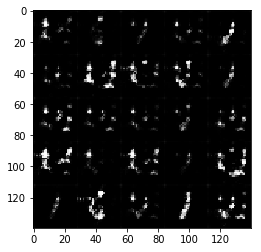

Epoch 1/2... Discriminator Loss: 0.6203... Generator Loss: 2.0389
Epoch 1/2... Discriminator Loss: 0.5440... Generator Loss: 2.8498
Epoch 1/2... Discriminator Loss: 0.7041... Generator Loss: 5.0155
Epoch 1/2... Discriminator Loss: 0.4703... Generator Loss: 3.7915
Epoch 1/2... Discriminator Loss: 0.5525... Generator Loss: 2.5560
Epoch 1/2... Discriminator Loss: 0.6686... Generator Loss: 1.9061
Epoch 1/2... Discriminator Loss: 0.5920... Generator Loss: 2.7605
Epoch 1/2... Discriminator Loss: 0.6839... Generator Loss: 2.2722
Epoch 1/2... Discriminator Loss: 0.5273... Generator Loss: 3.2014
Epoch 1/2... Discriminator Loss: 0.7301... Generator Loss: 2.1248


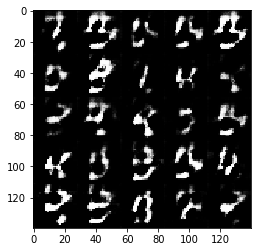

Epoch 1/2... Discriminator Loss: 0.8915... Generator Loss: 3.5562
Epoch 1/2... Discriminator Loss: 0.8783... Generator Loss: 3.6877
Epoch 1/2... Discriminator Loss: 1.1058... Generator Loss: 0.8606
Epoch 1/2... Discriminator Loss: 1.0371... Generator Loss: 0.9824
Epoch 1/2... Discriminator Loss: 0.6826... Generator Loss: 2.5300
Epoch 1/2... Discriminator Loss: 0.9783... Generator Loss: 3.8693
Epoch 1/2... Discriminator Loss: 0.8974... Generator Loss: 1.3116
Epoch 1/2... Discriminator Loss: 1.0100... Generator Loss: 3.0273
Epoch 1/2... Discriminator Loss: 0.8047... Generator Loss: 1.6788
Epoch 1/2... Discriminator Loss: 0.8639... Generator Loss: 1.2630


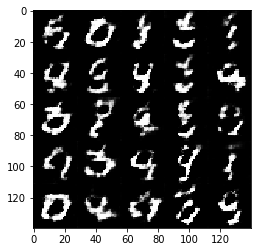

Epoch 1/2... Discriminator Loss: 1.0222... Generator Loss: 2.8365
Epoch 1/2... Discriminator Loss: 1.0362... Generator Loss: 0.9276
Epoch 1/2... Discriminator Loss: 1.1324... Generator Loss: 0.8478
Epoch 1/2... Discriminator Loss: 0.9620... Generator Loss: 1.3993
Epoch 1/2... Discriminator Loss: 0.9812... Generator Loss: 1.2060
Epoch 1/2... Discriminator Loss: 0.9068... Generator Loss: 1.3373
Epoch 1/2... Discriminator Loss: 1.1136... Generator Loss: 2.4837
Epoch 1/2... Discriminator Loss: 0.8649... Generator Loss: 1.2377
Epoch 1/2... Discriminator Loss: 0.8974... Generator Loss: 1.1430
Epoch 1/2... Discriminator Loss: 0.7848... Generator Loss: 2.3778


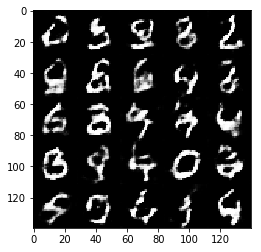

Epoch 1/2... Discriminator Loss: 0.9105... Generator Loss: 1.1589
Epoch 1/2... Discriminator Loss: 0.8720... Generator Loss: 1.3550
Epoch 1/2... Discriminator Loss: 1.1313... Generator Loss: 0.8041
Epoch 1/2... Discriminator Loss: 0.8900... Generator Loss: 1.1213
Epoch 1/2... Discriminator Loss: 0.7417... Generator Loss: 1.4405
Epoch 1/2... Discriminator Loss: 1.0215... Generator Loss: 0.9415
Epoch 1/2... Discriminator Loss: 0.8645... Generator Loss: 1.3097
Epoch 1/2... Discriminator Loss: 1.1608... Generator Loss: 2.9887
Epoch 1/2... Discriminator Loss: 0.8946... Generator Loss: 1.3584
Epoch 1/2... Discriminator Loss: 0.8270... Generator Loss: 1.6853


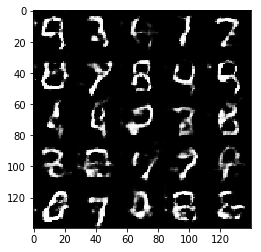

Epoch 2/2... Discriminator Loss: 1.0493... Generator Loss: 2.4085
Epoch 2/2... Discriminator Loss: 0.8040... Generator Loss: 1.5187
Epoch 2/2... Discriminator Loss: 0.7910... Generator Loss: 1.4014
Epoch 2/2... Discriminator Loss: 1.0054... Generator Loss: 2.0073
Epoch 2/2... Discriminator Loss: 1.1442... Generator Loss: 0.7242
Epoch 2/2... Discriminator Loss: 0.9900... Generator Loss: 0.9742
Epoch 2/2... Discriminator Loss: 0.8298... Generator Loss: 1.9191
Epoch 2/2... Discriminator Loss: 1.2056... Generator Loss: 0.6724
Epoch 2/2... Discriminator Loss: 1.2485... Generator Loss: 1.1079
Epoch 2/2... Discriminator Loss: 1.0380... Generator Loss: 1.0100


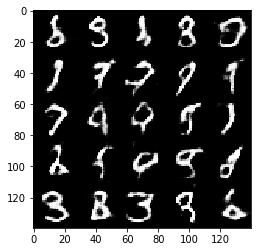

Epoch 2/2... Discriminator Loss: 1.2761... Generator Loss: 0.6409
Epoch 2/2... Discriminator Loss: 0.8563... Generator Loss: 1.5196
Epoch 2/2... Discriminator Loss: 1.0821... Generator Loss: 0.8512
Epoch 2/2... Discriminator Loss: 0.8889... Generator Loss: 1.3649
Epoch 2/2... Discriminator Loss: 1.0095... Generator Loss: 2.4902
Epoch 2/2... Discriminator Loss: 1.0260... Generator Loss: 0.8372
Epoch 2/2... Discriminator Loss: 0.9206... Generator Loss: 0.9645
Epoch 2/2... Discriminator Loss: 3.9301... Generator Loss: 5.4417
Epoch 2/2... Discriminator Loss: 1.2582... Generator Loss: 1.2999
Epoch 2/2... Discriminator Loss: 1.1263... Generator Loss: 1.1190


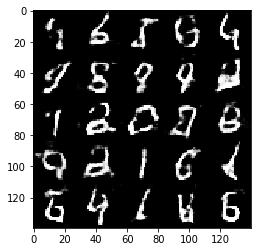

Epoch 2/2... Discriminator Loss: 1.1128... Generator Loss: 0.9793
Epoch 2/2... Discriminator Loss: 0.9589... Generator Loss: 2.2232
Epoch 2/2... Discriminator Loss: 0.8033... Generator Loss: 1.8271
Epoch 2/2... Discriminator Loss: 0.8259... Generator Loss: 2.3147
Epoch 2/2... Discriminator Loss: 0.9965... Generator Loss: 2.2939
Epoch 2/2... Discriminator Loss: 0.7828... Generator Loss: 2.3267
Epoch 2/2... Discriminator Loss: 1.0351... Generator Loss: 0.7961
Epoch 2/2... Discriminator Loss: 0.8614... Generator Loss: 1.2648
Epoch 2/2... Discriminator Loss: 0.8103... Generator Loss: 1.2270
Epoch 2/2... Discriminator Loss: 1.3909... Generator Loss: 0.5884


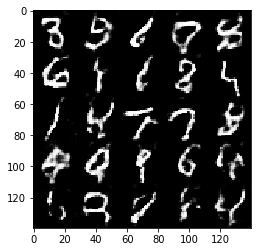

Epoch 2/2... Discriminator Loss: 0.7989... Generator Loss: 1.1567
Epoch 2/2... Discriminator Loss: 0.7861... Generator Loss: 1.3396
Epoch 2/2... Discriminator Loss: 0.8530... Generator Loss: 1.1081
Epoch 2/2... Discriminator Loss: 1.9956... Generator Loss: 0.3064
Epoch 2/2... Discriminator Loss: 1.0479... Generator Loss: 1.6522
Epoch 2/2... Discriminator Loss: 1.0247... Generator Loss: 0.8386
Epoch 2/2... Discriminator Loss: 0.8200... Generator Loss: 1.3401
Epoch 2/2... Discriminator Loss: 1.1510... Generator Loss: 0.6894
Epoch 2/2... Discriminator Loss: 0.8290... Generator Loss: 1.2089
Epoch 2/2... Discriminator Loss: 0.7828... Generator Loss: 1.2378


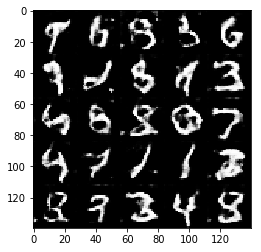

Epoch 2/2... Discriminator Loss: 0.9574... Generator Loss: 2.0393
Epoch 2/2... Discriminator Loss: 0.9918... Generator Loss: 1.7805
Epoch 2/2... Discriminator Loss: 0.9763... Generator Loss: 0.8940
Epoch 2/2... Discriminator Loss: 0.8741... Generator Loss: 2.1685
Epoch 2/2... Discriminator Loss: 0.8078... Generator Loss: 1.2151
Epoch 2/2... Discriminator Loss: 0.9364... Generator Loss: 1.0596
Epoch 2/2... Discriminator Loss: 0.9004... Generator Loss: 1.0256
Epoch 2/2... Discriminator Loss: 1.0658... Generator Loss: 0.8278
Epoch 2/2... Discriminator Loss: 1.0105... Generator Loss: 0.9631
Epoch 2/2... Discriminator Loss: 0.8965... Generator Loss: 1.0849


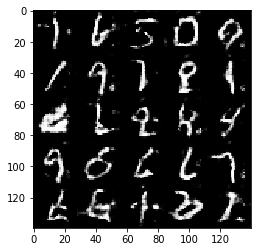

Epoch 2/2... Discriminator Loss: 1.8073... Generator Loss: 0.3530
Epoch 2/2... Discriminator Loss: 0.9785... Generator Loss: 0.9626
Epoch 2/2... Discriminator Loss: 0.8594... Generator Loss: 1.2371
Epoch 2/2... Discriminator Loss: 0.8545... Generator Loss: 1.1132
Epoch 2/2... Discriminator Loss: 0.9543... Generator Loss: 1.0574
Epoch 2/2... Discriminator Loss: 1.2481... Generator Loss: 0.6244
Epoch 2/2... Discriminator Loss: 0.8760... Generator Loss: 1.3207
Epoch 2/2... Discriminator Loss: 0.7118... Generator Loss: 1.6388
Epoch 2/2... Discriminator Loss: 0.8982... Generator Loss: 1.3029
Epoch 2/2... Discriminator Loss: 0.8394... Generator Loss: 1.6699


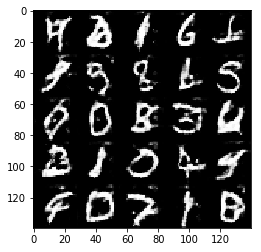

In [12]:
batch_size = 100
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5674... Generator Loss: 4.9812
Epoch 1/1... Discriminator Loss: 0.5582... Generator Loss: 11.9201
Epoch 1/1... Discriminator Loss: 0.5122... Generator Loss: 10.1303
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 0.5062... Generator Loss: 6.9530
Epoch 1/1... Discriminator Loss: 0.4901... Generator Loss: 6.8672
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 0.6236... Generator Loss: 2.2190
Epoch 1/1... Discriminator Loss: 2.0381... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 0.7298... Generator Loss: 1.8623


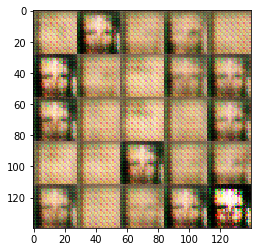

Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 4.2541
Epoch 1/1... Discriminator Loss: 0.7119... Generator Loss: 2.1912
Epoch 1/1... Discriminator Loss: 1.4968... Generator Loss: 6.6063
Epoch 1/1... Discriminator Loss: 0.5612... Generator Loss: 2.6345
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 1.6357
Epoch 1/1... Discriminator Loss: 1.8289... Generator Loss: 3.7008
Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 2.6099
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 1.2285
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 3.6097
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 3.8914


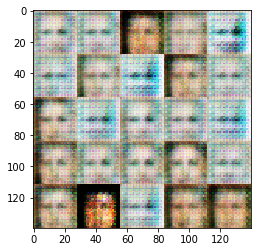

Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 1.5252
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 2.6958
Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 0.9378
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 1.4018
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 0.7760... Generator Loss: 1.4910
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 3.3660
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 1.3930
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 0.9004


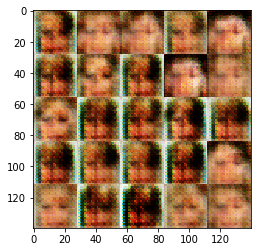

Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 2.0768
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 0.9325... Generator Loss: 1.2446
Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 1.4361
Epoch 1/1... Discriminator Loss: 2.3928... Generator Loss: 5.8114
Epoch 1/1... Discriminator Loss: 0.9218... Generator Loss: 1.9570
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.5506
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 2.1882
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 0.8636


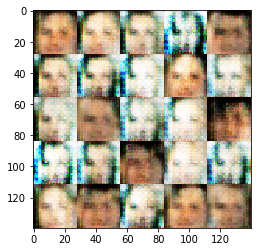

Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 1.0413
Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 1.3059
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 2.1993
Epoch 1/1... Discriminator Loss: 0.9864... Generator Loss: 1.0621
Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 2.1523
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 1.3376
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 1.7913
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.5862


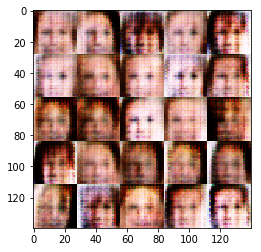

Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 0.8669... Generator Loss: 1.8696
Epoch 1/1... Discriminator Loss: 1.5845... Generator Loss: 0.4390
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 1.0228
Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 1.1087
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 2.7076
Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 1.1962
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 1.5955
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.5641


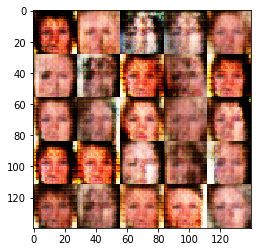

Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 1.3000
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 1.2350
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 1.3278
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 2.3051
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 1.1819
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 1.1461


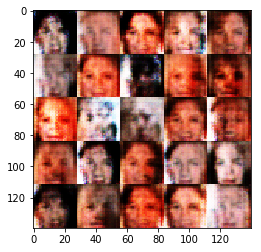

Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.1841... Generator Loss: 1.9529
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 2.0496
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 1.3046
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 1.4703
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.9873
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 1.2842
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 1.4893


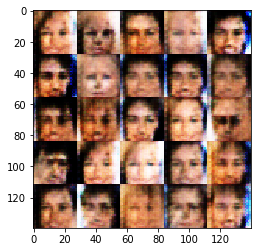

Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 1.5831
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 1.4386
Epoch 1/1... Discriminator Loss: 1.0384... Generator Loss: 1.0042
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 1.7679
Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 1.0990
Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 1.5178
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 1.0467
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 1.9200
Epoch 1/1... Discriminator Loss: 1.7067... Generator Loss: 2.7821
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 2.5937


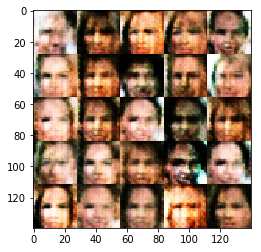

Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 2.0671
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 0.8575... Generator Loss: 1.5956
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 1.1684
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 1.4932
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 1.2848
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.6326


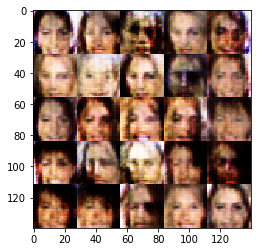

Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 1.4426
Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 1.4804
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 0.9079
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.5929
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.9607
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 1.4932
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 1.4051
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.5276
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 2.1140


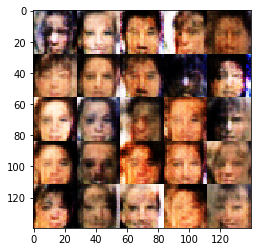

Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 1.2470
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 1.7390
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 1.8413
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 1.0902
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 1.1222
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 1.2921


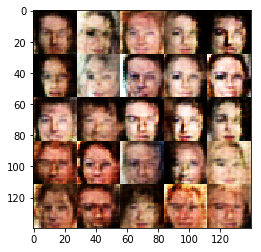

Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 1.8910
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.9835
Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 0.9065
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 1.1353
Epoch 1/1... Discriminator Loss: 0.9350... Generator Loss: 1.3318
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 1.3147
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 1.0368


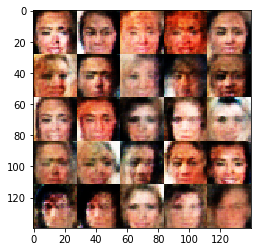

Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 1.2532
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 1.3914
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 1.1961
Epoch 1/1... Discriminator Loss: 0.9415... Generator Loss: 1.7415
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 1.3989
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 1.1673
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 1.1949
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.1190... Generator Loss: 1.3757
Epoch 1/1... Discriminator Loss: 1.9035... Generator Loss: 2.8141


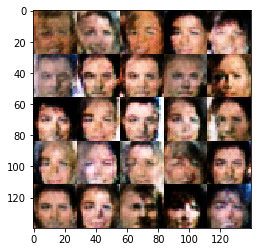

Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 1.1922
Epoch 1/1... Discriminator Loss: 0.9491... Generator Loss: 1.2331
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 1.4929
Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 1.7936
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 1.5656
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 1.0428
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 2.0085


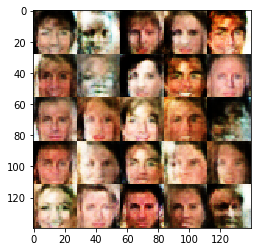

Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 1.4849
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 0.9945
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.5220
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 1.4747
Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 1.3338
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 1.5850
Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 1.5774
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 1.8676
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 1.2296


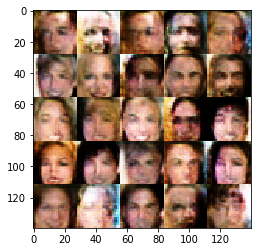

Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 1.3478
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 2.3132
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 1.8767
Epoch 1/1... Discriminator Loss: 0.9641... Generator Loss: 1.1314
Epoch 1/1... Discriminator Loss: 0.9764... Generator Loss: 1.5383
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 1.4654
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.5086
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.5499
Epoch 1/1... Discriminator Loss: 0.9883... Generator Loss: 1.3447
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.6449


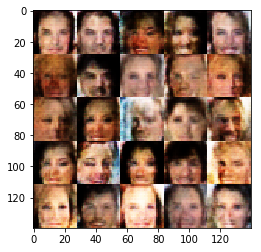

Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 1.0044
Epoch 1/1... Discriminator Loss: 1.9168... Generator Loss: 2.8425
Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 1.6648
Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 1.6664
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 0.9838
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.7896


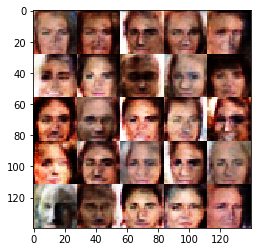

Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 1.4143
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 1.2974
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 1.0083
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 1.1068
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 1.4860
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.0107... Generator Loss: 1.1889
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 0.8301


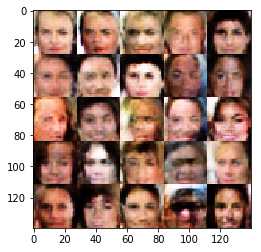

Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 1.0866
Epoch 1/1... Discriminator Loss: 1.0922... Generator Loss: 1.0589
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 1.5417
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 1.3086
Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 1.2077
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 0.9967
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 0.9429
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 1.6996
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 1.2015


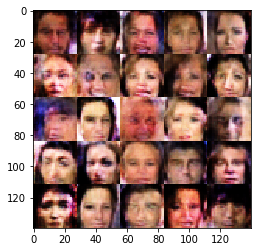

Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 1.9902
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 1.4371


In [13]:
batch_size = 100
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.